<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%205/05_1_Deteccion_de_centralidades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cosas que pasan juntas**

> Clustering para la detección de centralidades urbanas





<figure>
<center>
<img src='https://drive.google.com/uc?id=1QVx3I0_4uv7yA6DECpAo9VXJGvrq4og8' />
<figcaption></figcaption></center>
</figure>

Antes que nada, ¿qué entendemos por centralidad? Fundamentalmente, a aquellas actividades que suceden en un contexto de proximidad espacial. Es decir, cosas que pasan juntas o con cierta cercanía entre sí. 

Esto aplica a diferentes escalas, ya sea estemos trabajando con grupos de ciudades o dentro de una ciudad en sí misma. Hoy, nos vamos a enfocar en este último caso.

Los algoritmos de clustering son especialmente útiles para la identificación de centros de actividad. Ya sea para ver dónde se concentra la oferta de servicios en general o la de alguna categoría en particular. 

## 1. OSMnx: servicios en el Partido de General San Martín

 
[OSMnx](https://osmnx.readthedocs.io/en/stable/index.html) es una librería de python que permite consultar geometrías y construir redes de calles a partir de la API de [OpenStreeMap](https://www.openstreetmap.org). 

Para ello, trabaja básicamente a partir de una librería que no hemos visto durante el seminario: [NetworkX](https://networkx.github.io/documentation/stable/)

In [1]:
try:
    import geopandas as gpd
except:
    !pip install geopandas
    !pip install shapely

In [2]:
try:
    import osmnx as ox
except:
    !pip install osmnx
    import osmnx as ox

In [3]:
try:
    import networkx as nx
except:
    !pip install networkx
    import networkx as nx

In [4]:
import pandas as pd

### 1.1. Las geometrías y el uso de tags


OSMNx nos permite descargar distintos tipos de entidades con el módulo `geometries`. A través del mismo, se pueden consultar desde paradas de tránsito a distintos puntos de intéres como escuelas, negocios, edificios, barrios, etc.

Para hacer una consulta a la API, debemos utilizar [un diccionario con tags de OSM](https://wiki.openstreetmap.org/wiki/Map_features). Este debe especificar un string con el nombre del tag como key. 

Respecto de los values, estos pueden ser un booleano para devolver todos los objetos que en Openstreet usan dicho tag. También puede ser otro string con el nombre de una subcategoría con la que matchea el tag que seteamos en la key, o una lista de strings para devolver al menos alguna de las subcategorías con las que queremos que matchee nuestro tag.

In [5]:
# digamos que queremos consultar entidades que hayan sido taggeadas como edificios en una localidad especifica
localidad = 'José León Suárez, Partido de General San Martín, Buenos Aires, Argentina'
tags = {'building': True} 

edificios = ox.geometries_from_place(localidad, tags)
edificios.shape

(142, 27)

In [6]:
type(edificios)

geopandas.geodataframe.GeoDataFrame

In [7]:
# ... y ahora las que tengan un tag asociado a usos de suelo específicos. Digamos viviendas y basurales...
tags = {'landuse': ['residential','landfill']}

usos_suelo = ox.geometries_from_place(localidad, tags)
usos_suelo.shape

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


(14, 11)

In [8]:
# por ultimo, busquemos por una subcategoría en concreto. Por ejemplo, el barrio "Villa Hidalgo"
tags = {'name':'Villa Hidalgo'}
vh = ox.geometries_from_place(localidad, tags)
vh.shape

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


(2, 6)

In [9]:
# veamos que es lo que descargamos
vh

name          place  \
element_type osmid                                      
node         3825897569  Villa Hidalgo  neighbourhood   
way          525210889   Villa Hidalgo            NaN   

                                                                  geometry  \
element_type osmid                                                           
node         3825897569                        POINT (-58.58055 -34.51362)   
way          525210889   POLYGON ((-58.58923 -34.51020, -58.58820 -34.5...   

                                                                     nodes  \
element_type osmid                                                           
node         3825897569                                                NaN   
way          525210889   [5109775665, 5109775666, 5109775667, 510977566...   

                             landuse                                    source  
element_type osmid                                                              
node         3825897569          NaN                                       NaN  
way          525210889   residential  Registro_Provincial_de_Barrios_Populares

In [10]:
import matplotlib.pyplot as plt

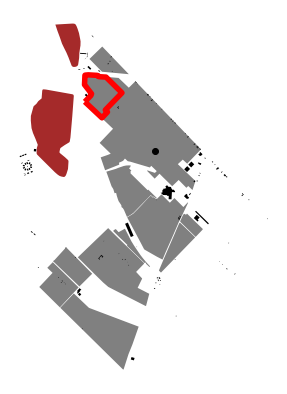

In [11]:
f, ax = plt.subplots(figsize=(12,7))

# preparamos nuestros layers
vh_polyg = vh[vh.geometry.apply(lambda x: x.type == 'Polygon')] # nos quedamos con la entidad que es un polígono!
usos_residenciales = usos_suelo.loc[usos_suelo.landuse == 'residential']
basurales = usos_suelo.loc[usos_suelo.landuse == 'landfill']

# ploteamos
usos_residenciales.plot(ax=ax, color='grey')
vh_polyg.geometry.boundary.plot(ax=ax, color='red', linewidth=5.5)
basurales.plot(ax=ax, color='brown')
edificios.plot(ax=ax, color='black')

ax.set_axis_off();

### Variando las referencias de nuestra consulta

Ahora que tenemos una idea de cómo funciona una consulta con OSMnx, traigamos distintos servicios que nos permitan construir centros de actividad en el partido. 

Decíamos que la idea de centralidad hace mención a servicios que suceden juntos. El tag `amenity` es un buen punto de partida para esto. 

#### Consultas a partir de un nombre

In [12]:
# si quisieramos traer algunas categorias
tags = {'amenity':['taxi','bank','cafe','bar',
                   'restaurant', 'university', 
                   'community_centre']}
#o simplemente todas
tags = {'amenity':True} # esta es la que vamos a estar usando

referencia = 'Partido de General San Martin, Buenos Aires, Argentina'

gdf = ox.geometries_from_place(query=referencia, tags=tags)
gdf.shape 

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


(698, 119)

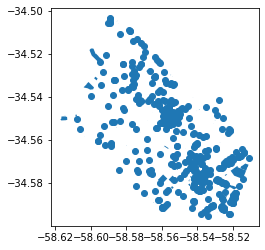

In [13]:
gdf.plot();

In [14]:
# tambien podemos buscar por el tipo de distrito
partido = 'Partido de General San Martín, Buenos Aires, Argentina'
tags = {'type': 'boundary'} 

sm = ox.geometries_from_place(partido, tags)
sm.shape

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


(36, 94)

In [15]:
sm.name.unique()

array(['Buenos Aires', 'Vicente López', 'Villa Martelli', 'Villa Adelina',
       'Florida Oeste', 'Munro', 'Partido de General San Martín',
       'Partido de Tres de Febrero', 'Partido de San Isidro',
       'Boulogne Sur Mer', 'Don Torcuato', 'Villa Devoto',
       'Villa Pueyrredón', 'Partido de Tigre', 'Partido de San Miguel',
       'Sáenz Peña', 'El Libertador', 'Loma Hermosa', 'Villa Bosch',
       'Santos Lugares', 'Caseros', 'Campo de Mayo',
       'Partido de Vicente López', 'Ciudad Autónoma de Buenos Aires',
       'Comuna 12', 'Comuna 11', 'José León Suárez', 'Villa Ballester',
       'San Andrés', 'Villa Maipú', 'General San Martín', 'Villa Lynch',
       'Billinghurst'], dtype=object)

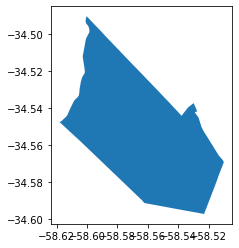

In [16]:
# asi podemos construir el limite del partido
sm[sm.name.isin(['Partido de General San Martín', 'General San Martín'])].reset_index().iloc[0:1].plot();

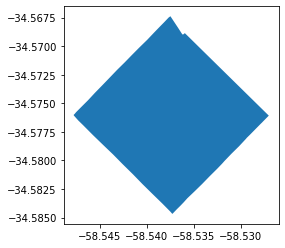

In [17]:
# o el de la localidad o distrinto central
sm[sm.name.isin(['Partido de General San Martín', 'General San Martín'])].reset_index().iloc[1:2].plot();

In [18]:
limite_partido = sm[sm.name.isin(['Partido de General San Martín'])].copy()
distrito_central = sm[sm.name.isin(['General San Martín'])].copy()
centroide = distrito_central.geometry.centroid

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


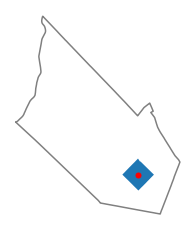

In [19]:
# estas son las capas de contexto con las que vamos a estar trabajando. Todas las construimos desde OSMnx
f, ax = plt.subplots()
limite_partido.geometry.boundary.plot(ax=ax, edgecolor='grey')
distrito_central.plot(ax=ax)
centroide.plot(ax=ax, markersize=25, color='red')
ax.set_axis_off();

#### Consultas a partir de un punto de referencia

In [20]:
ox.geometries_from_point?

In [21]:
# definimos como referencia el centroide del distrito central
referencia = (centroide.geometry.y.values[0],centroide.geometry.x.values[0])

In [22]:
referencia

(-34.576072308655306, -58.537440583038205)

Y establecemos una referencia para hacer la consulta ...

In [23]:
# area en km2 del distrito central
km2 = distrito_central.to_crs(3857).geometry.area.values/1000000 #pasamos de m2 a km2
print('La localidad de General San Martin tiene una superficie de {} km2'.format(round(km2[0],2)))

La localidad de General San Martin tiene una superficie de 2.69 km2


In [24]:
# calculamos la raiz cuadrada para obtener el largo de los lados del cuadrado
longitud = km2[0]**0.5
print('El area del distrito central es de {} km*{} km'.format(round(longitud,2), round(longitud,2))) 

El area del distrito central es de 1.64 km*1.64 km


In [25]:
# multiplicamos por mil para pasar de km2 a mts lineales. 
print('Un radio razonable para el buffer podria ser de {} mts'.format(round((longitud/2)*1000,2))) 

Un radio razonable para el buffer podria ser de 820.18 mts


/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for geom in data
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


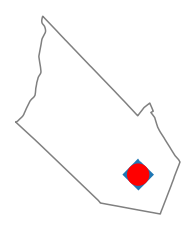

In [26]:
f, ax = plt.subplots()
limite_partido.to_crs(3857).geometry.boundary.plot(ax=ax, edgecolor='grey')
distrito_central.to_crs(3857).plot(ax=ax)
centroide.to_crs(3857).buffer(820).plot(ax=ax, markersize=1, color='red')

ax.set_axis_off();

In [27]:
# una buena referencia podria ser un buffer de mil metros!
tags = {'amenity':True}
gdf_ = ox.geometries_from_point(center_point=referencia, dist=1000, tags=tags)
gdf_.shape

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


(202, 90)

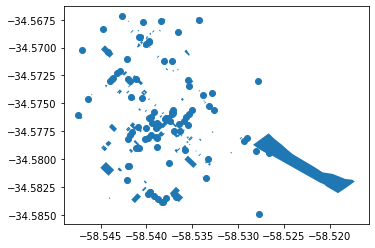

In [28]:
# vemos que tenemos poligonos y puntos
gdf_.plot();

### 1.2. Grafos?

Llamamos grafo a un tipo de estructura de datos compuesta por un conjunto de nodos o vértices unidos a través de ejes o arcos. No es la intención de este notebook adentrarnos en esta tipología. Pero mencionarla, y saber que con OSMnx podemos acceder a una representación de la red de calles de un distrito va a ser de mucha utilidad.

Empecemos probando cómo sería traernos el callejero de la localidad de General San Martín. 

In [29]:
G = ox.graph_from_place(partido, network_type='walk')

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [30]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

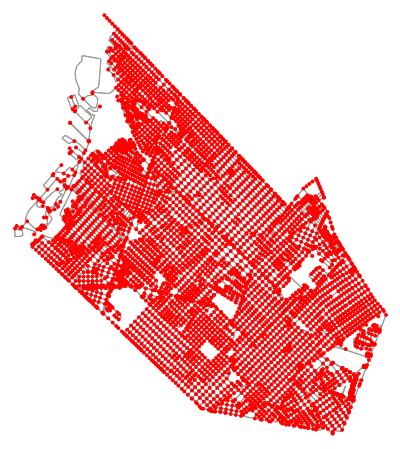

In [31]:
fig, ax = ox.plot_graph(G, bgcolor='w',node_color='r') # el callejero del partido, con nodos y arcos!

In [32]:
# asi accedemos a sus nodos (con sus respectivos atributos)
G.nodes(data=True)

NodeDataView({112308854: {'y': -34.5377998, 'x': -58.5295223, 'street_count': 3}, 112339554: {'y': -34.5396127, 'x': -58.5334353, 'highway': 'traffic_signals', 'street_count': 4}, 112416087: {'y': -34.5390539, 'x': -58.5325629, 'street_count': 3}, 112421774: {'y': -34.5385137, 'x': -58.531735, 'street_count': 3}, 113085681: {'y': -34.5431724, 'x': -58.5368218, 'highway': 'traffic_signals', 'street_count': 4}, 113094208: {'y': -34.5301774, 'x': -58.5537214, 'highway': 'traffic_signals', 'street_count': 4}, 113099394: {'y': -34.5328513, 'x': -58.5506252, 'highway': 'traffic_signals', 'street_count': 4}, 113099400: {'y': -34.5366155, 'x': -58.546269, 'highway': 'traffic_signals', 'street_count': 4}, 113099401: {'y': -34.5376905, 'x': -58.5450473, 'street_count': 3}, 113131484: {'y': -34.5357652, 'x': -58.5472535, 'street_count': 4}, 243674930: {'y': -34.5893154, 'x': -58.5191494, 'street_count': 5}, 243674932: {'y': -34.5802965, 'x': -58.5320106, 'highway': 'traffic_signals', 'street_coun

In [33]:
# e iteramos sobre sus atributos
for u,v in G.nodes(data=True):
  if v['street_count']<2: #nodos que cruzan menos de dos calles
    print(u)

244471262
290386993
290669792
290669805
290811139
290987667
321532559
482532370
573401004
574283095
574539128
617367688
670813495
670855743
670925505
670925507
684355609
684355711
720886788
972135365
987449325
987449338
987449871
1104232775
1107879034
1239469640
1239469654
1387870782
1406592074
1407894388
1407894436
1407894495
1407894504
1408771104
1408771164
1409304766
1409304831
1409304884
1508726210
1571713276
1576166054
1576166210
1576167993
1576180337
1576180458
1581304474
1754428811
1839362277
1839362281
1839362285
2038262067
2038262082
2038262346
2038262418
2052339056
2052348912
2052348922
2055591346
2151567332
2151576262
2151576265
2151583971
2151583972
2151583978
2151593158
2155694286
2453370269
2484145383
2494601647
2505019611
2506002702
2506002743
2506002757
2506002772
2506002785
2506002791
2506002843
2643055802
2725122028
2725122032
2725122061
2725122068
2725122120
3018719373
3021857906
3023393799
3026612973
3026612978
3026612979
3026612985
3026612988
3026612992
3026612998


In [34]:
# Lo mismo con los ejes
G.edges(data=True)

OutMultiEdgeDataView([(112308854, 950499734, {'osmid': 85099533, 'oneway': False, 'name': 'Avenida 1 - Sir Alexander Fleming', 'highway': 'secondary', 'length': 76.384}), (112308854, 1836681780, {'osmid': 375751600, 'oneway': False, 'name': 'Avenida 1 - Sir Alexander Fleming', 'highway': 'secondary', 'length': 62.856}), (112339554, 112416087, {'osmid': 84503736, 'oneway': False, 'name': 'Luis María Drago', 'highway': 'secondary', 'length': 101.223}), (112339554, 471276796, {'osmid': 26342466, 'lanes': '1', 'name': '9 - Canese', 'highway': 'residential', 'maxspeed': '40', 'oneway': False, 'length': 294.818, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f796304d750>}), (112339554, 471275639, {'osmid': 81539575, 'oneway': False, 'name': 'Luis María Drago', 'highway': 'secondary', 'length': 251.17399999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f796304d510>}), (112416087, 112339554, {'osmid': 84503736, 'oneway': False, 'name': 'Luis María Dr

In [35]:
# y sus atributos
for u,v,k in G.edges(data=True):
  if k['length'] < 1:
    print(u,v)

4005111106 7474298222
5825344755 5825344782
5825344782 5825344755
7474298222 4005111106


## 2. DBSCAN: Identificando centros de actividad

In [36]:
import numpy as np
from sklearn.cluster import DBSCAN

Para identificar clusters con las geometrías que consultamos, vamos a trabajar con la implementación de [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) que ofrece scikit learn.

Sus siglas vienen de `Density-based Spatial Clustering of Applications with Noise`, lo que ya nos da alguna pista sobre su funcionamiento. Este algoritmo determina categorías de agrupamiento a partir de cuan densa es un área en términos de la concentración de puntos (o coordenadas) existentes. Cuan denso estará determinado por dos parametros principales: `eps` y `min_samples`. 

Para mayor información pueden leer la página de [Wikipedia](https://es.wikipedia.org/wiki/DBSCAN). Si quieren explorar otros algoritmos de clustering, les dejamos [este articulo](https://towardsdatascience.com/clustering-in-geospatial-applications-which-model-should-you-use-59a039332c45).


<figure>
<center>
<img src='https://drive.google.com/uc?id=1mCaIGA8rWLRAkhDd9WRcyj1OOV6wyUNz' />
<figcaption></figcaption></center>
</figure>

### 2.1. Clusters en el partido de San Martín

In [37]:
# cargamos algunas capas de contexto extra
manzanas = gpd.read_file('https://storage.googleapis.com/python_mdg/carto_cursos/Polyg_371.zip')
localidades = gpd.read_file('https://storage.googleapis.com/python_mdg/carto_cursos/localidades.zip')

/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/federico/federico/AUPY/venv/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [38]:
len(gdf[gdf.geometry.apply(lambda x: x.type != 'Polygon')])

450

In [39]:
gdf[gdf.geometry.apply(lambda x: x.type != 'Polygon')]['amenity'].unique()

array(['fuel', 'police', 'school', 'bar', 'pharmacy', 'parking_entrance',
       'bank', 'fast_food', 'cafe', 'clinic', 'atm', 'telephone',
       'post_box', 'recycling', 'kindergarten', 'car_wash', 'parking',
       'post_office', 'prison', 'university', 'fire_station',
       'restaurant', 'library', 'place_of_worship', 'bench', 'hospital',
       'taxi', 'ice_cream', 'events_venue', 'courthouse', 'pub',
       'doctors', 'dentist', 'veterinary', 'internet_cafe',
       'payment_centre', 'driving_school', 'community_centre', 'theatre',
       'drinking_water', 'love_hotel', 'toilets', 'public_bookcase',
       'vending_machine'], dtype=object)

In [40]:
# nos quedamos solo con los puntos
gdf_puntos = gdf[gdf.geometry.apply(lambda x: x.type != 'Polygon')].copy()

Existen dos caminos para estimar clusters con DBSCAN, trabajando con coordenadas geográficas o proyectadas.

**1. Reproyectando nuestras coordenadas**

In [41]:
#lo pasamos a una proyeccion con unidades de medida en metros para usar distancia euclidiana
gdf_puntos_mts = gdf_puntos.to_crs(epsg = 3857)
#extraemos esas coordenadas en metros
gdf_puntos_mts['x'] = gdf_puntos_mts.geometry.x
gdf_puntos_mts['y'] = gdf_puntos_mts.geometry.y

#construimos las coordenadas en el formato que requiere DBSCAN
X = gdf_puntos_mts.reindex(columns = ['x','y']).values

#construimos el objeto DBSCAN con nuestros dos parametros 
clustering = DBSCAN(eps=1000, #la distancia minima entre servicios para considerarlos "cerca"
                    min_samples=50 # la cantidad minima de actividades o servicios en un grupo
                    ).fit(X)
# guardamos la clasificacion en una columna en nuestro dataframe. -1 es en ningun grupos significativo
gdf_puntos_mts.loc[:,'k'] = clustering.labels_

#vemos una distirbucion de frecuencias para ver cantidad de estaciones dentro de cada grupo
gdf_puntos_mts['k'].value_counts(normalize = True) * 100

-1    48.222222
 1    26.444444
 0    25.333333
Name: k, dtype: float64

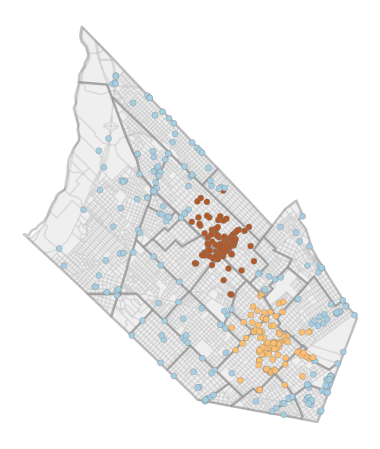

In [42]:
#visualizamos en un mapa
f,ax = plt.subplots(figsize = (8,8))
manzanas.to_crs(3857).plot(ax=ax, color='grey', edgecolor='grey', linewidth=1.5, alpha = 0.2)
localidades.to_crs(3857).plot(ax=ax, color='white', edgecolor='grey', linewidth=2.5, alpha = 0.4)
gdf_puntos_mts.plot(column = 'k',ax=ax, categorical = True, cmap='Paired', edgecolor='grey', linewidth=0.3)

ax.set_axis_off()

**2. Sin reproyectar, trabajando con radianes**

In [43]:
# creamos coordenadas
gdf_puntos['x'] = gdf_puntos.geometry.x
gdf_puntos['y'] = gdf_puntos.geometry.y

También existe la posibilidad de utilizar una distancia de ['Haversine'](https://www.ehowenespanol.com/calcular-distancia-puntos-latitud-longitud-como_452715/) para calcular la distancia entre dos puntos siguiendo el radio de la esfera/Tierra.

El parámetro `algorithm` puede recibir distintos valores. Para establecer relaciones de vecindad se pueden usar varios (aca la documentacion oficial sobre el módulo [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html) que realiza esta tarea). En este [articulo](https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940) tambien pueden encontrar algunas definiciones mas detalladas. 

Nosotros vamos a explorar dos, el que viene por default y `ball-tree` que nos permite trabajar con la distancia haversine. Por default, el parámetro `metric` determina distancia euclideana en mts.

In [44]:
# establecemos el formato requerido con latitud y longitud
coords = gdf_puntos.reindex(columns=['y', 'x']).values

# cantidad de km en un radian. Esta es la medida de la haversine distance
kms_per_radian = 6371.0088

# definamos un epsilon de mil metros. Es necesario convertir a radianes para tranajar con haversine
epsilon = 1 / kms_per_radian

db = DBSCAN(eps=epsilon, 
            min_samples=50, 
            algorithm='ball_tree', 
            metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# obtenemos el numero de clusters
num_clusters = len(set(cluster_labels))

In [45]:
num_clusters

3

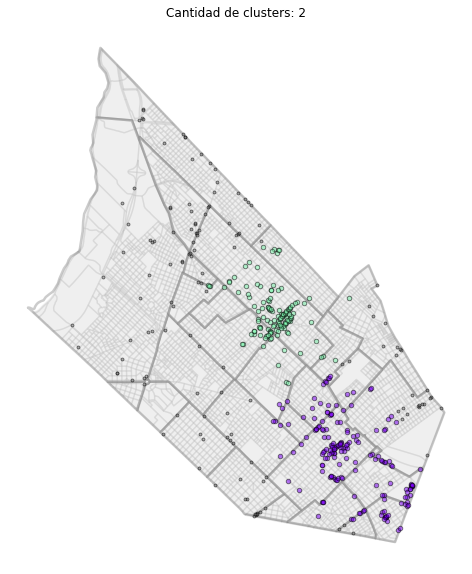

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
# construimos colores para cada cluster, a partir del len de unique labels
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# capas de contexto
manzanas.to_crs(4326).plot(ax=ax, color='grey', edgecolor='grey', linewidth=1.5, alpha = 0.2)
localidades.to_crs(4326).plot(ax=ax, color='white', edgecolor='grey', linewidth=2.5, alpha = 0.4)

# para cada cluster label y color, ploteamos un punto
for cluster_label, color in zip(unique_labels, colors):
    
    size = 20
    if cluster_label == -1: # hacemos que los puntos atípicos (-1) se vean grises y más chicos
        color = 'gray'
        size = 8
    
    # ploteamos los puntos que matchean en cada cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, color=color, edgecolor='k', s=size, alpha=0.5)



ax.set_title('Cantidad de clusters: {}'.format(num_clusters-1))
ax.patch.set_facecolor('#F7F7F7')
ax.axis('off')
plt.show();

### 2.2. Clusters en la localidad de General San Martin

In [47]:
# nos quedamos solo con los puntos en el distrito de san martin
gdf_puntos_ = gdf_[gdf_.geometry.apply(lambda x: x.type != 'Polygon')].copy()

In [48]:
gdf_puntos_mts_ = gdf_puntos_.to_crs(epsg = 3857)
gdf_puntos_mts_['x'] = gdf_puntos_mts_.geometry.x
gdf_puntos_mts_['y'] = gdf_puntos_mts_.geometry.y

X_ = gdf_puntos_mts_.reindex(columns = ['x','y']).values

clustering_ = DBSCAN(eps=100, 
                     min_samples=5 
                     ).fit(X_)

gdf_puntos_mts_.loc[:,'k'] = clustering_.labels_

gdf_puntos_mts_['k'].value_counts(normalize = True) * 100

-1    68.421053
 1    16.842105
 2     8.421053
 0     6.315789
Name: k, dtype: float64

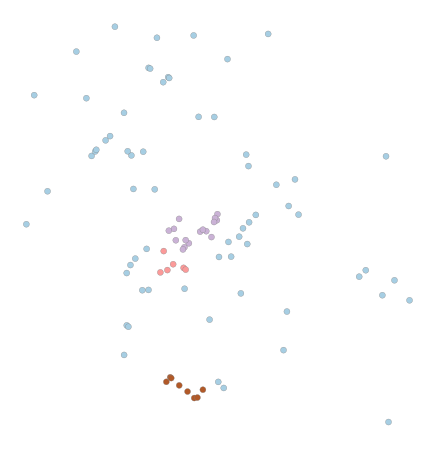

In [49]:
#visualizamos los tres clusters
f,ax = plt.subplots(figsize = (8,8))
#manzanas.to_crs(3857).plot(ax=ax, color='grey', edgecolor='grey', linewidth=1.5, alpha = 0.2)
#localidades.to_crs(3857).plot(ax=ax, color='white', edgecolor='grey', linewidth=2.5, alpha = 0.4)

gdf_puntos_mts_.plot(column = 'k',ax=ax, categorical = True, cmap='Paired', edgecolor='grey', linewidth=0.3)

ax.set_axis_off()

### 2.3. Identificando nodos próximos 

In [50]:
# conseguimos las coordenadas de nuestros nodos
coords = np.array([[v['y'],v['x']] for u,v in G.nodes(data=True)])

In [51]:
# cantidad de nodos
len(G.nodes)

5901

In [52]:
kms_per_radian = 6371.0088

# un epsilon de 200 mts.
epsilon = 0.2 / kms_per_radian

db = DBSCAN(eps=epsilon, 
            min_samples=50, 
            algorithm='ball_tree', 
            metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
unique_labels = set(cluster_labels)

num_clusters = len(set(cluster_labels))

In [53]:
num_clusters

8

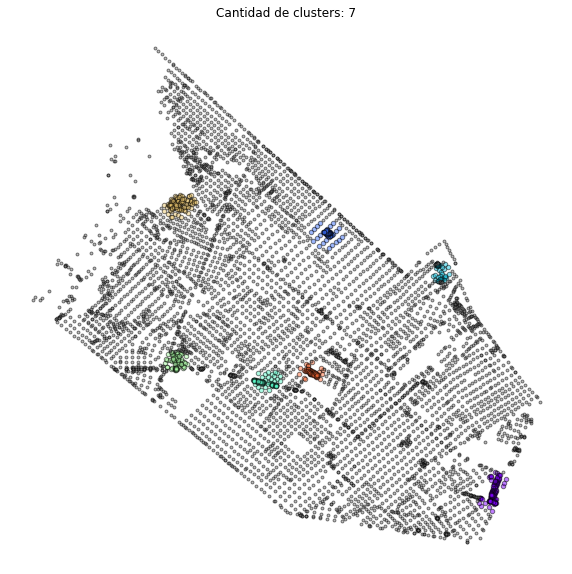

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for cluster_label, color in zip(unique_labels, colors):
    
    size = 20
    if cluster_label == -1: 
        color = 'gray'
        size = 8
    
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, color=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Cantidad de clusters: {}'.format(num_clusters-1))
ax.patch.set_facecolor('#F7F7F7')
ax.axis('off')
plt.show();